In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
%cd "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN"

/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN


In [5]:
!pip install pyyaml h5py

This notebook follows a [tutorial from LearningOpenCV](https://learnopencv.com/implementing-cnn-tensorflow-keras/) for building a simple CNN in TensorFlow using Keras. This CNN will be used to classify images from the CIFAR-10 dataset.

In [11]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from dataclasses import dataclass

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


We see that we have a total of 60000 images (6000 per each of ten categories, as it turns out), and these images are 32 x 32 three-channel (RGB) images. Further, the data is split into 50000 training samples and 10000 test samples.

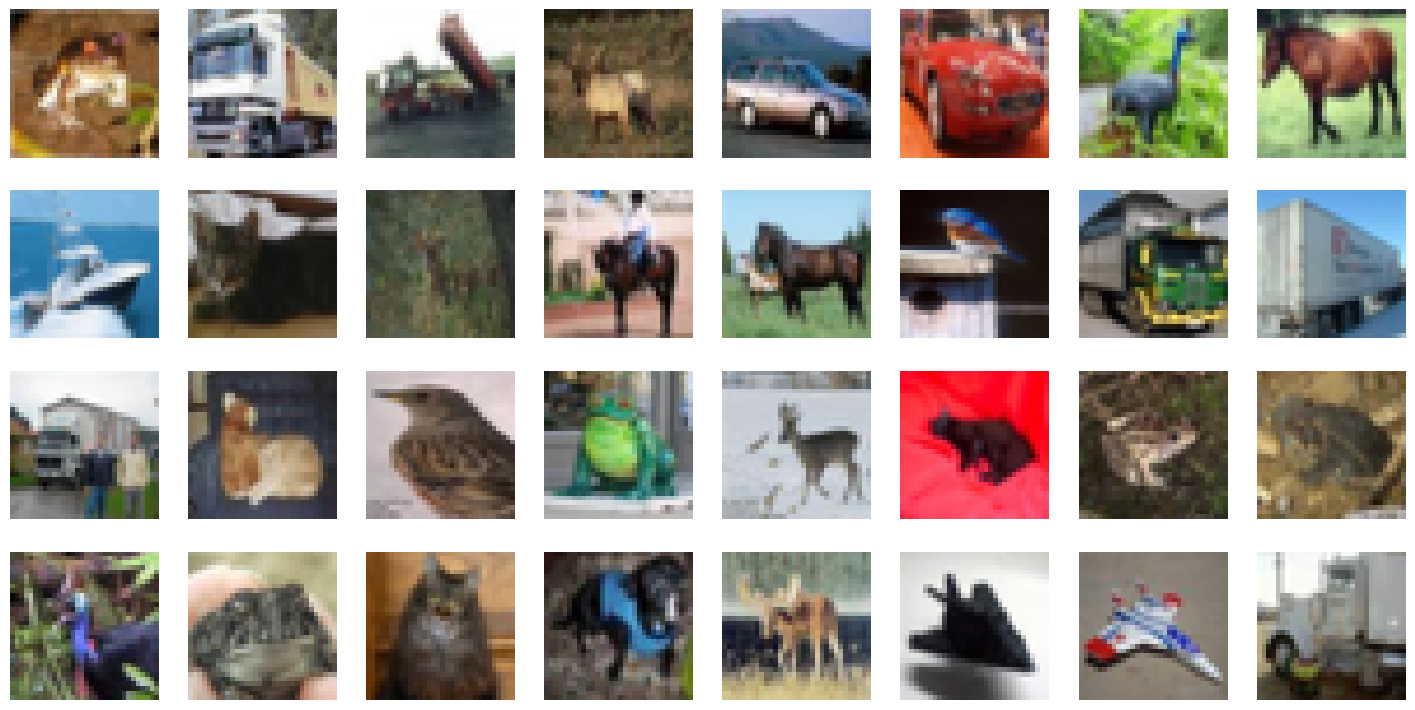

In [8]:
plt.figure(figsize = (18,9))
num_rows = 4
num_cols = 8
for i in range(0,num_rows*num_cols):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(X_train[i,:,:])
  plt.axis("off")
plt.show()

We perform some data preprocessing. We normalize the RGB values by dividing by 255 so that the data is in the range [0,1]. We also one-hot encode the categorical target values.

In [9]:
# convert pixel data to float and normalize
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
# one-hot encode categorical targets
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
print(y_train.shape)

(50000, 10)


In [7]:
@dataclass(frozen = True)
class DatasetConfig:
  NUM_CLASSES:  int = 10
  IMG_HEIGHT:   int = 32
  IMG_WIDTH:    int = 32
  NUM_CHANNELS: int = 3

@dataclass(frozen = True)
class TrainingConfig:
  EPOCHS:         int = 31
  BATCH_SIZE:     int = 256
  LEARNING_RATE:  float = 0.001

We create a function to define our CNN. The CNN will have three convolutional modules, each composed of two convolutions and a max pooling. The convolutions in the first module will each have a kernel size of 3x3 and a depth of 32, and we will use a window size of 2x2 for the max pooling. Additionally, we will set padding to "same" and maintain a stride of one throughout such that the output from the first convolutional module will be 16x16x32. The subsequent convolutional modules will be identical except they will be composed of convolutions with depths of 64. After passing through the second convolutional module, the output will be 8x8x64, and after passing through the final convolutional module it will be 4x4x64.

After the three convolutional modules, the output will be flattened, passed through a 512-neuron dense layer, and finally passed through a 10-neuron dense layer with softmax activation, returning our class probabilities.

We will use a ReLU activation everywhere except in the final softmax layer.

In [12]:
def cnn_model(input_shape = (32, 32, 3)):
  model = Sequential()
  '''
  Convolutional module 1: 32 filters + MaxPool
  '''
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Flatten and add dense layers
  '''
  model.add(Flatten())
  model.add(Dense(units = 512, activation = "relu"))
  model.add(Dense(units = 10, activation = "softmax"))

  return model

In [13]:
model = cnn_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,354 (2.55 MB)

 Trainable params: 669,354 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

At model checkpoints so we do not have to retrain our model.

In [14]:
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

When training, we specify the argument validation_split = 0.3. This will split off 30 percent of our training data to act as validation data, in addition to the test data (independently used to assess generalization error) above.

In [15]:
history = model.fit(X_train,
                    y_train,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = TrainingConfig.EPOCHS,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1808 - loss: 2.1996
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.1812 - loss: 2.1988 - val_accuracy: 0.3617 - val_loss: 1.7627
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3729 - loss: 1.7304
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.3731 - loss: 1.7300 - val_accuracy: 0.4214 - val_loss: 1.6184
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4674 - loss: 1.5079
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-l

In [34]:
# save history dictionary in case we have to restart notebook
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

In [32]:
# reload history
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history.json"
with open(savepath, "r") as f:
  history = json.load(f)

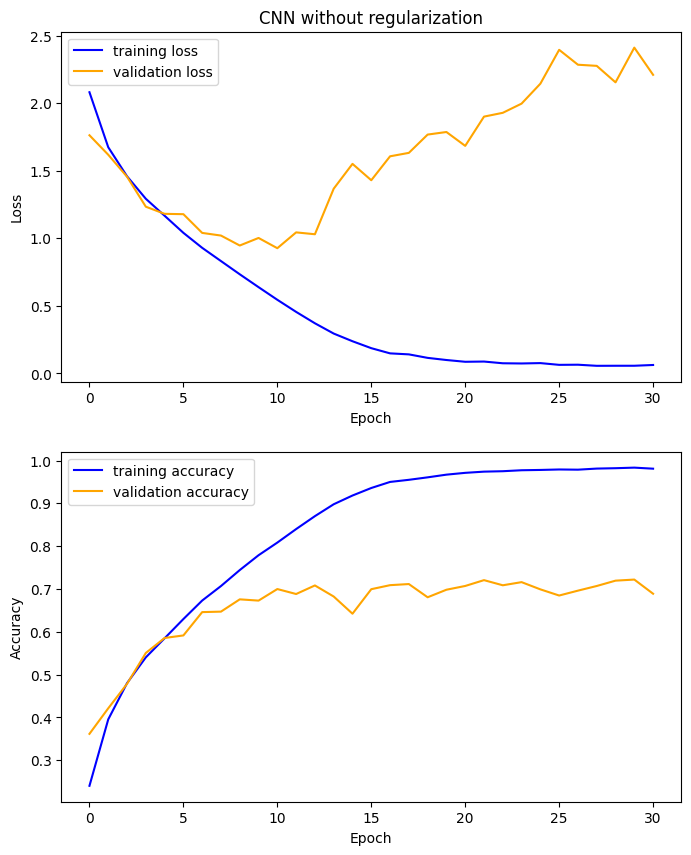

In [38]:
plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history["loss"], label = "training loss", color = "blue")
plt.plot(history["val_loss"], label = "validation loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("CNN without regularization")
plt.legend()
ax = plt.subplot(2,1,2)
plt.plot(history["accuracy"], label = "training accuracy", color = "blue")
plt.plot(history["val_accuracy"], label = "validation accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

We see that, after about 10 epochs, our validation loss begins to increase again, indicating overfitting. At the same time, the validation accuracy stagnates at roughly 70%. Let's try two regularization methods to counteract overfitting and see if this improves our model (and maybe training) performance. In the first model, we will add dropout with a 25% rate after each max pooling step in the convolutional modules and dropout with a 50% rate after the first dense layer.

In the second model, we will use batch normalization, adding a normalization layer after each convolutional layer and after our first dense layer.

In [15]:
def cnn_model_dropout(input_shape = (32, 32, 3)):
  model = Sequential()
  '''
  Convolutional module 1: 32 filters + MaxPool
  '''
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  '''
  Flatten and add dense layers
  '''
  model.add(Flatten())
  model.add(Dense(units = 512, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(units = 10, activation = "softmax"))

  return model

In [16]:
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,354 (2.55 MB)

 Trainable params: 669,354 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_dropout.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [41]:
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_dropout.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [42]:
history = model_dropout.fit(X_train,
                    y_train,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = TrainingConfig.EPOCHS,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1435 - loss: 2.2533
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_dropout.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.1439 - loss: 2.2527 - val_accuracy: 0.3533 - val_loss: 1.7939
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3248 - loss: 1.8453
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_dropout.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.3250 - loss: 1.8450 - val_accuracy: 0.2979 - val_loss: 1.8715
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3915 - loss: 1.6502
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine

In [43]:
# save history dictionary in case we have to restart notebook
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_dropout.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

In [18]:
def cnn_model_batch_normalization(input_shape = (32, 32, 3)):
  model = Sequential()
  '''
  Convolutional module 1: 32 filters + MaxPool
  '''
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  '''
  Flatten and add dense layers
  '''
  model.add(Flatten())
  model.add(Dense(units = 512, activation = "relu"))
  model.add(BatchNormalization())
  model.add(Dense(units = 10, activation = "softmax"))

  return model

In [19]:
model_batch_normalization = cnn_model_batch_normalization()
model_batch_normalization.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 672,682 (2.57 MB)

 Trainable params: 671,018 (2.56 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [20]:
model_batch_normalization.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [48]:
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [53]:
history = model_batch_normalization.fit(X_train,
                    y_train,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = TrainingConfig.EPOCHS,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4192 - loss: 1.8372
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.4198 - loss: 1.8346 - val_accuracy: 0.1019 - val_loss: 3.5017
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6588 - loss: 0.9677
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.6589 - loss: 0.9675 - val_accuracy: 0.2041 - val_loss: 3.9122
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7536 - loss: 0.7041
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/mach

In [54]:
# save history dictionary in case we have to restart notebook
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_batch_normalization.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

In [30]:
# load the histories of each of our models into a dictionary
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_names = ["history.json", "history_dropout.json", "history_batch_normalization.json"]
history_names = ["history", "history_dropout", "history_batch_normalization"]
history_dict = {}
for file_name, history_name in zip(file_names, history_names):
  loadpath = prefix + file_name
  with open(loadpath, "r") as f:
    history_dict[history_name] = json.load(f)

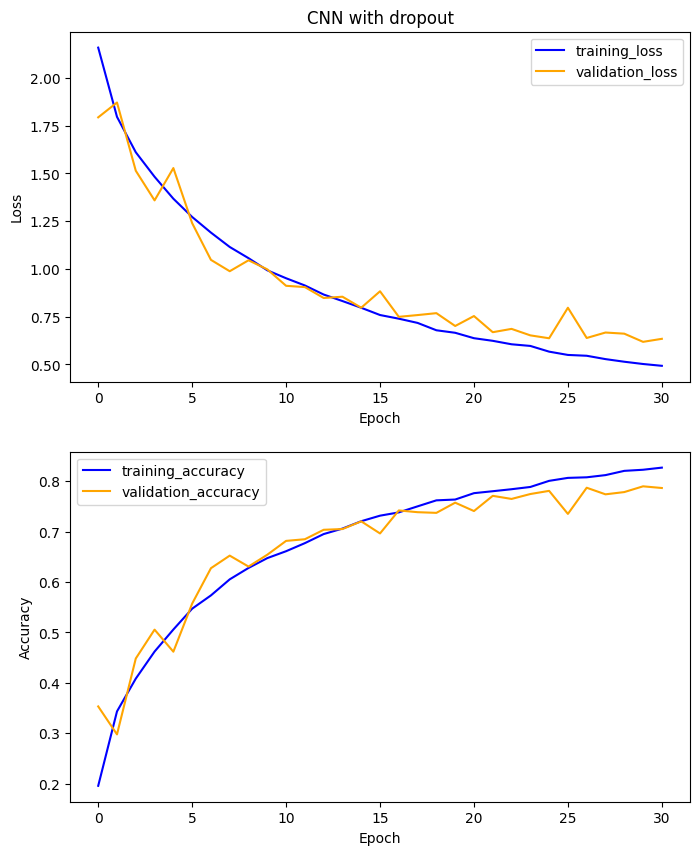

In [40]:
plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history_dict["history_dropout"]["loss"], label = "training_loss", color = "blue")
plt.plot(history_dict["history_dropout"]["val_loss"], label = "validation_loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("CNN with dropout")
plt.legend()
ax = plt.subplot(2,1,2)
plt.plot(history_dict["history_dropout"]["accuracy"], label = "training_accuracy", color = "blue")
plt.plot(history_dict["history_dropout"]["val_accuracy"], label = "validation_accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

We see that the performance of the CNN with dropout is improved. It appears to have just converged after 31 epochs to a validation accuracy of roughly 79%.

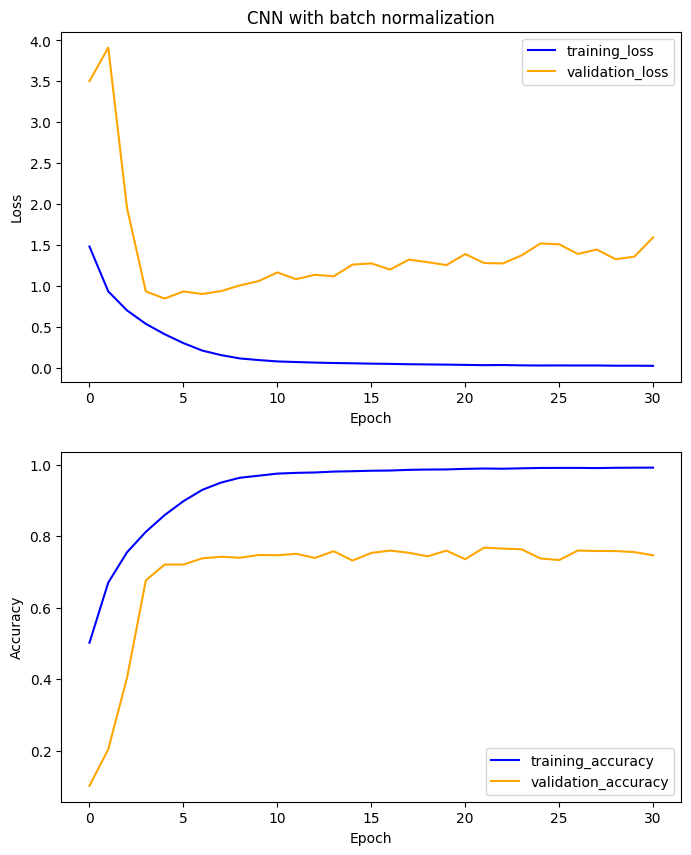

In [42]:
plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history_dict["history_batch_normalization"]["loss"], label = "training_loss", color = "blue")
plt.plot(history_dict["history_batch_normalization"]["val_loss"], label = "validation_loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("CNN with batch normalization")
plt.legend()
ax = plt.subplot(2,1,2)
plt.plot(history_dict["history_batch_normalization"]["accuracy"], label = "training_accuracy", color = "blue")
plt.plot(history_dict["history_batch_normalization"]["val_accuracy"], label = "validation_accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Interestingly, our model with batch normalization achieves a peak validation accuracy of around 76%, an improvement over the unregularized CNN, but it does so much more quickly than the CNN with dropout. The model is converged after only 4 or 5 epochs and experiences over-fitting after this, with the validation loss slowly increasing and the validation accuracy slowly decaying.

Let's train a new model with batch normalization over only 5 epochs and compare its performance to our fully trained dropout model.

In [43]:
model_batch_normalization2 = cnn_model_batch_normalization()
model_batch_normalization2.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)
history = model_batch_normalization2.fit(X_train,
                    y_train,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = 5,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_batch_normalization2.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_names = ["history.json", "history_dropout.json", "history_batch_normalization.json", "history_batch_normalization2.json"]
history_names = ["history", "history_dropout", "history_batch_normalization", "history_batch_normalization2"]
history_dict = {}
for file_name, history_name in zip(file_names, history_names):
  loadpath = prefix + file_name
  with open(loadpath, "r") as f:
    history_dict[history_name] = json.load(f)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4143 - loss: 1.8641
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization2.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.4149 - loss: 1.8615 - val_accuracy: 0.1556 - val_loss: 3.1780
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6533 - loss: 0.9830
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_batch_normalization2.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6534 - loss: 0.9827 - val_accuracy: 0.2053 - val_loss: 3.4392
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7574 - loss: 0.6923
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machi

In [47]:
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_names = ["cnn1_dropout.weights.h5", "cnn1_batch_normalization2.weights.h5"]
model_dropout = cnn_model_dropout()
model_dropout.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model_dropout.load_weights(prefix + file_names[0])
model_batch_normalization = cnn_model_batch_normalization()
model_batch_normalization.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model_batch_normalization.load_weights(prefix + file_names[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
test_loss, test_acc = model_dropout.evaluate(X_test, y_test)
print(f"Dropout model test accuracy: {test_acc*100:.3f}")
test_loss, test_acc = model_batch_normalization.evaluate(X_test, y_test)
print(f"Batch normalization model test accuracy: {test_acc*100:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7951 - loss: 0.6416
Dropout model test accuracy: 79.020
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7175 - loss: 0.9008
Batch normalization model test accuracy: 71.290


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


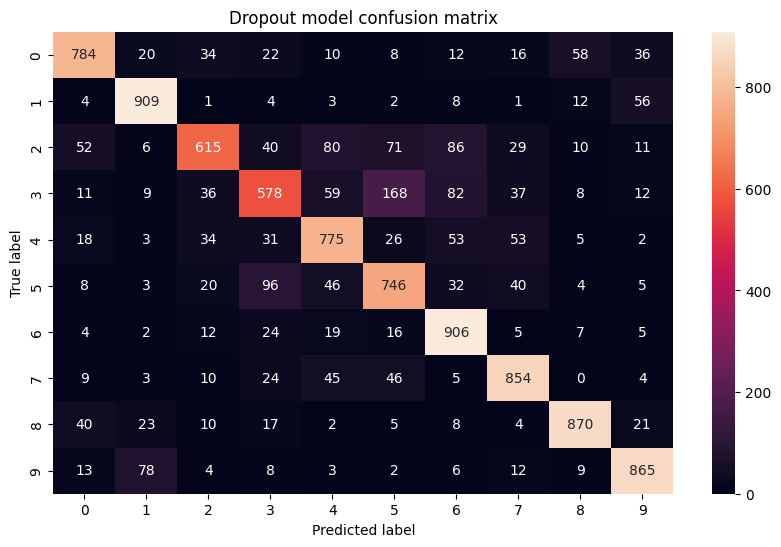

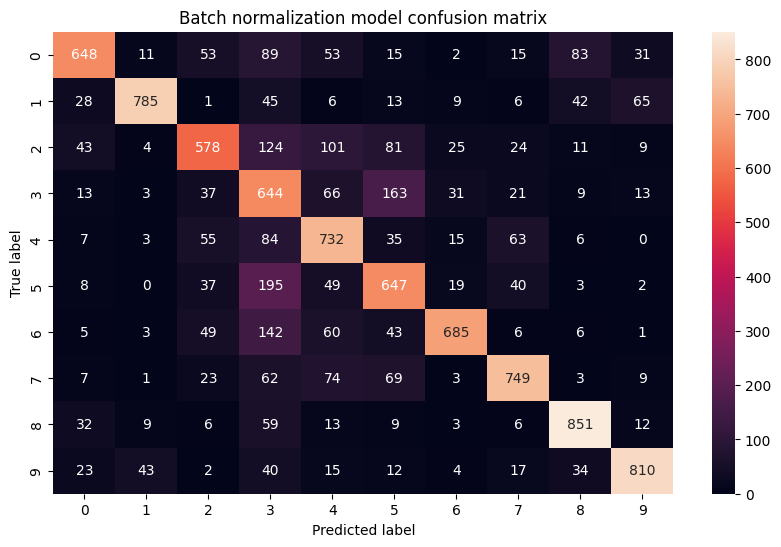

In [49]:
# make predictions and convert one-hot encoded predictions to integer class labels
predictions_dropout = model_dropout.predict(X_test)
predicted_labels_dropout = [np.argmax(i) for i in predictions_dropout]
predictions_batch_normalization = model_batch_normalization.predict(X_test)
predicted_labels_batch_normalization = [np.argmax(i) for i in predictions_batch_normalization]
# convert one-hot encoded test data to integer class labels
y_integer_test_labels = tf.argmax(y_test, axis = 1)

cm_dropout = tf.math.confusion_matrix(labels = y_integer_test_labels,
                                      predictions = predicted_labels_dropout)
plt.figure(figsize = (10,6))
sns.heatmap(cm_dropout, annot = True, fmt = "d", annot_kws = {"size": 10})
plt.title("Dropout model confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

cm_batch_normalization = tf.math.confusion_matrix(labels = y_integer_test_labels,
                                      predictions = predicted_labels_batch_normalization)
plt.figure(figsize = (10,6))
sns.heatmap(cm_batch_normalization, annot = True, fmt = "d", annot_kws = {"size": 10})
plt.title("Batch normalization model confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

As a final step, let's play around with transfer learning. We will train a model on a subset of the CIFAR-10 data, teaching it how to classify dogs and cats. We will then retrain the predictive and final convolutional modules to distinguish between horses and deers to see if the ability to recognize the early features of dogs and cats transfers to this task at all.

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# dog and cat data
X_train_dc = X_train[np.logical_or(y_train.reshape(-1) == 3, y_train.reshape(-1) == 5)] # 3 = cat, 5 = dog
X_test_dc = X_test[np.logical_or(y_test.reshape(-1) == 3, y_test.reshape(-1) == 5)]
y_train_dc = y_train[np.logical_or(y_train.reshape(-1) == 3, y_train.reshape(-1) == 5)]
y_test_dc = y_test[np.logical_or(y_test.reshape(-1) == 3, y_test.reshape(-1) == 5)]
# horse and deer data
X_train_hd = X_train[np.logical_or(y_train.reshape(-1) == 4, y_train.reshape(-1) == 7)] # 4 = deer, 7 = horse
X_test_hd = X_test[np.logical_or(y_test.reshape(-1) == 4, y_test.reshape(-1) == 7)]
y_train_hd = y_train[np.logical_or(y_train.reshape(-1) == 4, y_train.reshape(-1) == 7)]
y_test_hd = y_test[np.logical_or(y_test.reshape(-1) == 4, y_test.reshape(-1) == 7)]
# one-hot encode class labels

# normalize pixel data
X_train_dc = X_train_dc.astype("float32")/255
X_test_dc = X_test_dc.astype("float32")/255
X_train_hd = X_train_hd.astype("float32")/255
X_test_hd = X_test_hd.astype("float32")/255
# convert to binary with dog/horse = 0, cat/deer = 1
y_train_dc[y_train_dc == 3] = 1
y_train_dc[y_train_dc == 5] = 0
y_test_dc[y_test_dc == 3] = 1
y_test_dc[y_test_dc == 5] = 0
y_train_hd[y_train_hd == 4] = 1
y_train_hd[y_train_hd == 7] = 0
y_test_hd[y_test_hd == 4] = 1
y_test_hd[y_test_hd == 7] = 0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [82]:
# define new CNN model for binary prediction
def cnn_model_binary(input_shape = (32, 32, 3)):
  model = Sequential()
  '''
  Convolutional module 1: 32 filters + MaxPool
  '''
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  #model.add(Dropout(0.25))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  #model.add(Dropout(0.25))
  '''
  Convolutional module 2: 64 filters + MaxPool
  '''
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   activation = "relu", input_shape = input_shape))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  #model.add(Dropout(0.25))
  '''
  Flatten and add dense layers
  '''
  model.add(Flatten())
  model.add(Dense(units = 512, activation = "relu"))
  #model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = "sigmoid"))

  return model

In [83]:
model = cnn_model_binary()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,737 (2.54 MB)

 Trainable params: 664,737 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [85]:
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dc.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [86]:
history = model.fit(X_train_dc,
                    y_train_dc,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = TrainingConfig.EPOCHS,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.4926 - loss: 0.6933
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dc.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 987ms/step - accuracy: 0.4932 - loss: 0.6932 - val_accuracy: 0.5270 - val_loss: 0.6890
Epoch 2/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5384 - loss: 0.6890
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dc.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 941ms/step - accuracy: 0.5384 - loss: 0.6890 - val_accuracy: 0.5910 - val_loss: 0.6833
Epoch 3/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.5885 - loss: 0.6755
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-

In [87]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dc.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

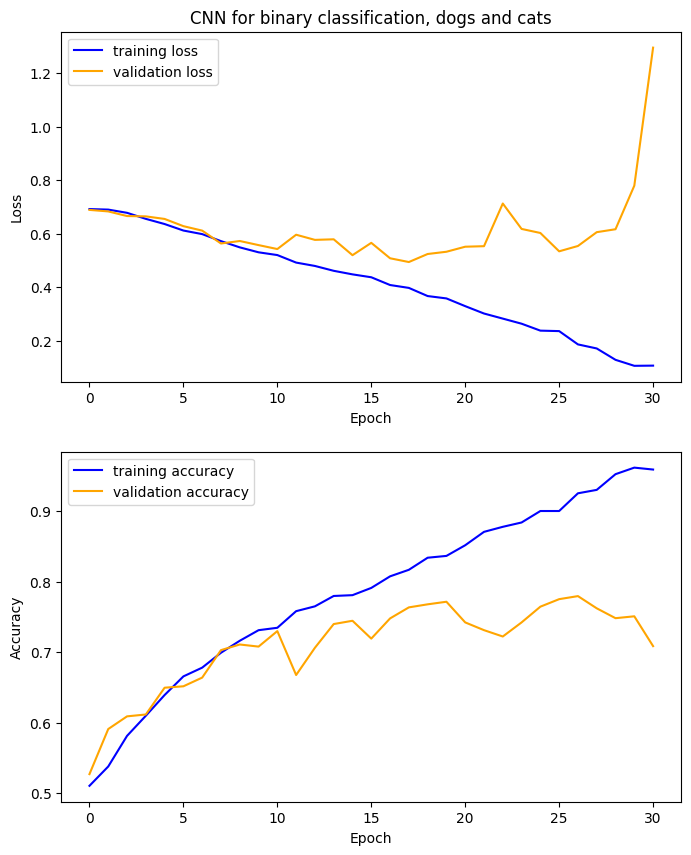

In [92]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dc.json"
with open(savepath, "r") as f:
  history = json.load(f)

fig = plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history["loss"], label = "training loss", color = "blue")
plt.plot(history["val_loss"], label = "validation loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("CNN for binary classification, dogs and cats")
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(history["accuracy"], label = "training accuracy", color = "blue")
plt.plot(history["val_accuracy"], label = "validation accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

Interestingly, the CNN model with all of our dropout steps could not train on this binary classification problem.

In the end, achieving a model that could obtain reasonable validation accuracy (~80%) and avoid overfitting took a significant amount of trial and error. The original model architecture was prone to overfitting, yet it would not fit at all if too much dropout was included. Likely, this is a reflection of the relative paucity of data in our training set.

Below is the architecture arrived at through trial and error. It is a composition of three 3x3 filter layers with ReLU activations in a row, each followed by a 2x2 max pooling layer and a dropout layer with a 50% dropout rate. The first convolutional layer contains 32 filters while the last two contain 64. After passing through the convolutional units (convolution + max pooling + dropout), the data was passed through a 512-unit fully connected ReLU layer and then a single sigmoid unit (our binary prediction).

In [18]:
# define new CNN model for binary prediction
def cnn_model_binary_dropout(input_shape = (32, 32, 3)):
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
                   input_shape = input_shape))
  #model.add(BatchNormalization())
  model.add(Activation(activations.relu))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   input_shape = input_shape))
  #model.add(BatchNormalization())
  model.add(Activation(activations.relu))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
                   input_shape = input_shape))
  #model.add(BatchNormalization())
  model.add(Activation(activations.relu))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))

  #model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",
  #                 activation = "relu", input_shape = input_shape))

  #model.add(Dropout(0.25))
  #'''
  #Convolutional module 2: 64 filters + MaxPool
  #'''
  #model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
  #                 activation = "relu"))
  #model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same",
  #                 activation = "relu", input_shape = input_shape))
  #model.add(MaxPooling2D(pool_size = (2, 2)))
  #model.add(Dropout(0.25))
  '''
  Flatten and add dense layers
  '''
  model.add(Flatten())
  model.add(Dense(units = 512, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = "sigmoid"))

  return model

In [19]:
model = cnn_model_binary_dropout()
model.summary()
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dropout_dc.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 581,633 (2.22 MB)

 Trainable params: 581,633 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train_dc,
                    y_train_dc,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = 121,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/121
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.4922 - loss: 0.8220
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dropout_dc.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.4924 - loss: 0.8191 - val_accuracy: 0.5020 - val_loss: 0.6921
Epoch 2/121
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.5309 - loss: 0.6900
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_dropout_dc.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 616ms/step - accuracy: 0.5312 - loss: 0.6900 - val_accuracy: 0.5043 - val_loss: 0.6906
Epoch 3/121
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5376 - loss: 0.6895
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/ma

In [21]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dropout_dc.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

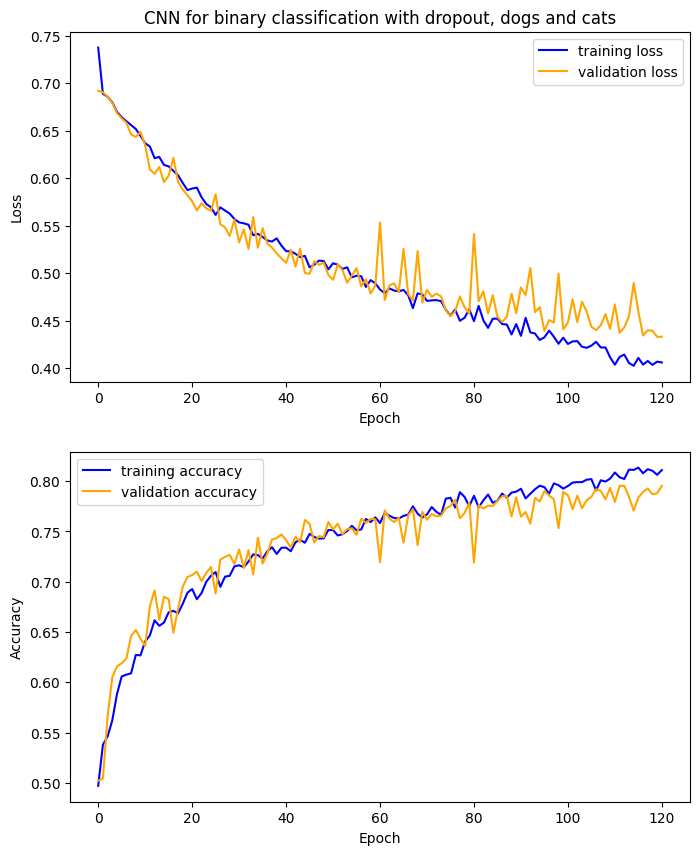

In [22]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dropout_dc.json"
with open(savepath, "r") as f:
  history = json.load(f)

fig = plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history["loss"], label = "training loss", color = "blue")
plt.plot(history["val_loss"], label = "validation loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("CNN for binary classification with dropout, dogs and cats")
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(history["accuracy"], label = "training accuracy", color = "blue")
plt.plot(history["val_accuracy"], label = "validation accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

Let's evaluate our model on our hold out set:

In [24]:
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_name = "cnn1_binary_dropout_dc.weights.h5"
model = cnn_model_binary_dropout()
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.load_weights(prefix + file_name)
test_loss, test_acc = model.evaluate(X_test_dc, y_test_dc)
print(f"Dropout model test accuracy: {test_acc*100:.3f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7939 - loss: 0.4299
Dropout model test accuracy: 79.650


The model is able to correctly classify dogs and cats with 75.7% accuracy, compared to a random chance accuracy of 50%.

Now, let's see if we can transfer the first two convolutional layers to a model for differentiating between deer and horses and obtain any improvement in training performance.

In [36]:
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_name = "cnn1_binary_dropout_dc.weights.h5"
model = cnn_model_binary_dropout()
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.load_weights(prefix + file_name)

for i in range(0,len(model.layers)):
  print("layer " + str(i) + ": " + str(model.layers[i]))

layer 0: <Conv2D name=conv2d_46, built=True>
layer 1: <Activation name=activation_45, built=True>
layer 2: <MaxPooling2D name=max_pooling2d_45, built=True>
layer 3: <Dropout name=dropout_60, built=True>
layer 4: <Conv2D name=conv2d_47, built=True>
layer 5: <Activation name=activation_46, built=True>
layer 6: <MaxPooling2D name=max_pooling2d_46, built=True>
layer 7: <Dropout name=dropout_61, built=True>
layer 8: <Conv2D name=conv2d_48, built=True>
layer 9: <Activation name=activation_47, built=True>
layer 10: <MaxPooling2D name=max_pooling2d_47, built=True>
layer 11: <Dropout name=dropout_62, built=True>
layer 12: <Flatten name=flatten_15, built=True>
layer 13: <Dense name=dense_30, built=True>
layer 14: <Dropout name=dropout_63, built=True>
layer 15: <Dense name=dense_31, built=True>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


We want to freeze the first two convolutional units (convolution + activation + max pooling + dropout), which we see corresponds to layer indices 0 through 7.

In [41]:
for i in range(0,8):
  model.layers[i].trainable = False
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_46 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 581,633 (2.22 MB)

 Trainable params: 562,241 (2.14 MB)

 Non-trainable params: 19,392 (75.75 KB)

We see that this represents a modest reduction in the number of trainable parameters because most of the trainable parameters correspond to the connections between the final convolutional layer (4x4x64) and the first dense layer (512 units) for a total of (4x4x64 + 1)x512 = 524800 weights.

Let's see how well this model performs under fine-tuning:

In [42]:
checkpoint_path = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_hd_finetuning1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)
history = model.fit(X_train_hd,
                    y_train_hd,
                    batch_size = TrainingConfig.BATCH_SIZE,
                    epochs = 61,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6749 - loss: 0.6374
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_hd_finetuning1.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.6760 - loss: 0.6352 - val_accuracy: 0.7380 - val_loss: 0.5282
Epoch 2/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7594 - loss: 0.4968
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/cnn1_binary_hd_finetuning1.weights.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.7594 - loss: 0.4967 - val_accuracy: 0.7740 - val_loss: 0.4779
Epoch 3/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7683 - loss: 0.4798
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.i

In [43]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dropout_hd_finetuning1.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

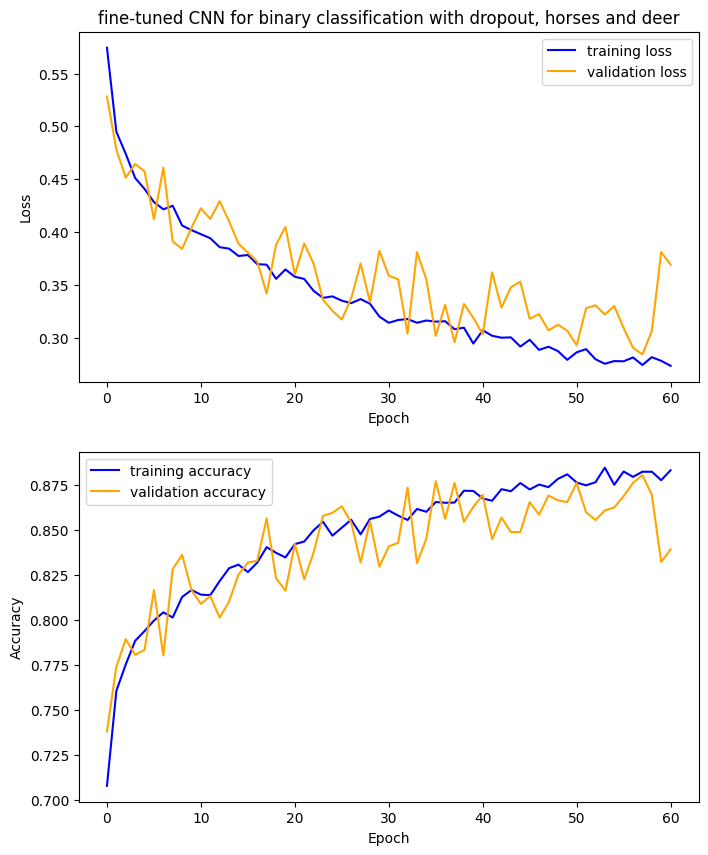

In [44]:
savepath = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/history_binary_dropout_hd_finetuning1.json"
with open(savepath, "r") as f:
  history = json.load(f)

fig = plt.figure(figsize = (8,10))
ax = plt.subplot(2,1,1)
plt.plot(history["loss"], label = "training loss", color = "blue")
plt.plot(history["val_loss"], label = "validation loss", color = "orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("fine-tuned CNN for binary classification with dropout, horses and deer")
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(history["accuracy"], label = "training accuracy", color = "blue")
plt.plot(history["val_accuracy"], label = "validation accuracy", color = "orange")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

We see that this does indeed seem to enhance our training, with our validation accuracy starting off at 73.8% after the first epoch, an improvement over both random chance (50%) and the validation accuracy after the first epoch of the dog/cat discriminator model (50.2%).

Additionally, this model trains to a much better validation accuracy than the dog/cat discriminator. Likely this is because discriminating between horses and deer is an easier task than discriminating between dogs and cats.

Let's take a look at our test accuracy:

In [47]:
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_name = "cnn1_binary_hd_finetuning1.weights.h5"
model = cnn_model_binary_dropout()
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.load_weights(prefix + file_name)

test_loss, test_acc = model.evaluate(X_test_hd, y_test_hd)
print(f"Dropout model test accuracy: {test_acc*100:.3f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8563 - loss: 0.3323
Dropout model test accuracy: 85.200


Evaluation on our holdout data indicates this model is able to discriminate between horses and deer with roughly 85% accuracy.

Finally, let's look at the confusion matrix for this model to get a more accurate picture of the distribution of true/false positives/negatives:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


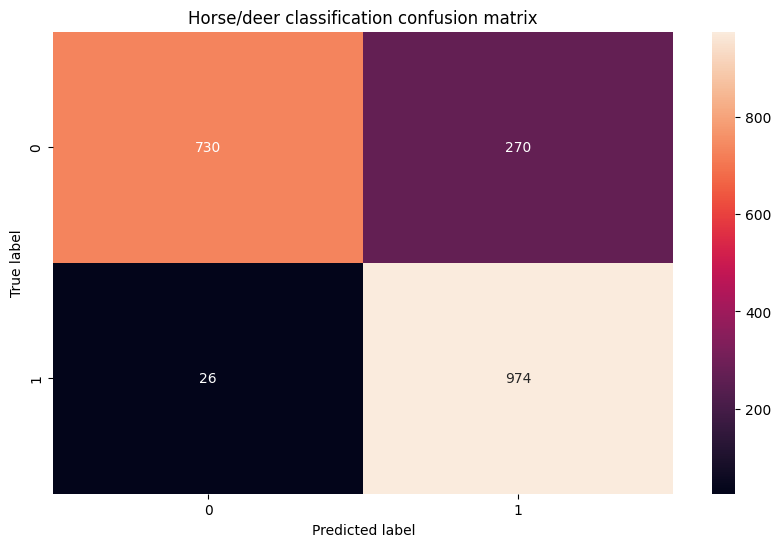

In [60]:
prefix = "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/CNN/checkpoints/"
file_name = "cnn1_binary_hd_finetuning1.weights.h5"
model = cnn_model_binary_dropout()
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.load_weights(prefix + file_name)

predictions_hd = model.predict(X_test_hd)
predictions_hd[predictions_hd <= 0.5] = 0
predictions_hd[predictions_hd > 0.5] = 1

cm_dropout = tf.math.confusion_matrix(labels = y_test_hd.reshape(-1),
                                      predictions = predictions_hd.reshape(-1))
plt.figure(figsize = (10,6))
sns.heatmap(cm_dropout, annot = True, fmt = "d", annot_kws = {"size": 10})
plt.title("Horse/deer classification confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

Interestingly, we see that the rate of misclassifying horses as deer is about 10 times that of misclassifying deer as horses.